# Multi-Stage Processes Notebook

In [1]:
### Import packages
import polars as pl
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import itertools
from collections import Counter

# For plotting
import seaborn as sns

sns.set_theme(style="ticks")
sns.axes_style("darkgrid")
sns.set_theme()

from IPython.display import display, HTML

# For storing DataFrames
import pickle

import sys
from os import getcwd
sys.path.append(getcwd())
import MultiStagePackage.OptMSPfunctions as msp
from MultiStagePackage.models import *

from itertools import islice
import collections
from ast import literal_eval

# For optimization
from pygmo import *

In [2]:
### Prepare data

## Models
models_numeric = [WT_anaerob_growth, 
          LC_anaerob_growth, 
          WT_aerob_growth, 
          LC_aerob_growth, 
          WT_anaerob_growth_arrest, 
          LC_anaerob_growth_arrest]

models_analytic = [WT_anaerob_growth_analyt, 
          LC_anaerob_growth_analyt, 
          WT_aerob_growth_analyt, 
          LC_aerob_growth_analyt, 
          WT_anaerob_growth_arrest_analyt, 
          LC_anaerob_growth_arrest_analyt]

## initial conditions
X_0 = 0.1    # gDW/L
S_0 = 100.0  # mmol/L 
P_0 = 0.0    # mmol/L
s = np.array([X_0, S_0, P_0])

## Indexing
X, S, P = (i for i in range(len(s)))
r_S, r_P, mu = (i for i in range(3))

## The ```stage``` function

The stage functions are recursive functions. Two functions, analytical (```stage_ana()```) and ODE/numeric(```stage_num()```), are provided. They are independent of the number of stages the user wants to try out. 


**stage_ana()**= function that calculates in a recursive analytical manner all models that are given as input.
- ```stage_ana(combi, models, s, times, finished=0)```
  - ```combi```     = combinations as list (e.g. ```[1,2,3]```) 
  - ```models```    = all models in list format
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```times```     = starting time, time switches (due to user on how many time switches/stages are tried out) and end time as list (e.g. ```[0,1,24]``` = t=0 at start, switch to next module/stage at t=1 and end time at t=24)
  - ```finished```  = variable displaying stage at which fermentation finished as integer (e.g. ```2``` = finished in stage 2 (stop is set at when substrate = 0)) **Note**: if fermentation is not finished (substrate still available at t end) this variable is set to ```np.Inf```
  - **OUTPUT**= returns biomass (at end time), substrate (at end time), product (at end time), end time and value of the ```finished``` variable 

<br/>

**stage_num()**= function that calculates in a recursive simulation/ODE-based manner all models that are given as input.
- ```stage_num(combi, models, s, times, finished=0, step=0.01)``` 
  - ```combi```     = combinations as list (e.g. ```[1,2,3]```) 
  - ```models```    = all models in list format
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100., 0. ])```)
  - ```times```     = starting time, time switches (due to user on how many time switches/stages are tried out) and end time as list (e.g. ```[0,1,24]``` = t=0 at start, switch to next module/stage at t=1 and end time at t=24)
  - ```finished```  = variable displaying stage at which fermentation finished as integer (e.g. ```2``` = finished in stage 2 (stop is set at substrate = 0))
  - ```step```      = maximal step size in integrator: scipy.integrate.solve_ivp() as float and default=0.01 
  - **OUTPUT**= returns biomass (at end time), substrate (at end time), product (at end time), end time and value of the ```finished``` variable

In [3]:
### Examples for numeric and analytic models

# They are given two time points for start and end and return a list with Biomass, Substrate and Product at the end time point
# The ana returns also the end time point as last value:
times = [0, 1]  # Input time points
combi = [0, 1]  # Modules from parameter table (see above)

# Analytic model:
result_ana = models_analytic[int(combi[0])](s, times[0], times[1])
print(result_ana)
# ODE/numeric model:
result_num = sp.integrate.solve_ivp(models_numeric[int(combi[0])],t_span=[times[0], times[1]],y0=s,t_eval=[times[1]],dense_output=True,max_step=0.01,).y.T
print(result_num[0])

# Equal?
print("Are model outputs equal?")
print(np.round(result_ana[0:3],10) == np.round(result_num[0],10))

[0.11388283833246218, 98.27746013613373, 2.7883146835429806, 1]
[ 0.11388284 98.27746014  2.78831468]
Are model outputs equal?
[ True  True  True]


In [4]:
### Examples for stage_ana() and stage_num()

# These functions call (if a multi stage is set) multiple times modules depending on what strategy you want to use.
## 1-Stage (to see that the same results from examples above are returned)
print("1-Stage analytical-based:")
print(msp.stage_ana(combi=[0], models=models_analytic, s=s, times=[0, 1]))
print("1-Stage simulation-based:")
print(msp.stage_num(combi=[0], models=models_numeric, s=s, times=[0, 1]))
# The "inf" in the output tells you that the fermentation was not finished yet (meaning not all substrate was consumed)

### Examples: stage_ana()
## 2-Stage
print("2-Stage analytical-based:")
print(msp.stage_ana(combi=[0, 1], models=models_analytic, s=s, times=[0, 1, 24]))
# biomass(t=end)    = 0.372
# substrate(t=end)  = 0.0
# product(t=end)    = 180.126
# end time          = 20.721
# stage were fermentation finished = 2

## For better understanding try to set the end time (here 24) to 19 and see what happens with the finished (last) value in the list




# _________________________________________________________________________________________
## 4-Stage
print("4-Stage analytical-based:")
print(msp.stage_ana(combi=[0, 1, 2, 3], models=models_analytic, s=s, times=[0, 1, 2, 16, 24]))


### Examples: stage_num()
## 2-Stage
print("2-Stage simulation-based:")
print(msp.stage_num(combi=[0, 1], models=models_numeric, s=s, times=[0, 1, 24]))
## 4-Stage
print("4-Stage simulation-based:")
print(msp.stage_num(combi=[0, 1, 2, 3], models=models_numeric, s=s, times=[0, 1, 2, 16, 24]))

1-Stage analytical-based:
[0.11388283833246218, 98.27746013613373, 2.7883146835429806, 1, inf]
1-Stage simulation-based:
[0.11388283833246224, 98.27746013613374, 2.7883146835429824, 1, inf]
2-Stage analytical-based:
[0.37182892792861366, 0.0, 180.12625128089715, 20.721061522537394, 2]
4-Stage analytical-based:
[6.644428132000827, 2.842170943040401e-14, 9.1351969778886, 9.704545618387222, 3]
2-Stage simulation-based:
[0.37182746890856905, 0.0005558866374957003, 180.12524820461581, 20.72106114508865, 2]
4-Stage simulation-based:
[6.644389357019039, 0.0005682026177304617, 9.135188029815886, 9.704544940552076, 3]


## Brute force approaches

If the user wants to not only try out single module/time-switch combinations, but rather many different settings then the functions ```doBruteForceAna()``` and ```doBruteForceNum()``` are provided.

**doBruteForceAna()** = function that takes as many different combinations of different parameters and times as the user provides and calculates those analytically
- ```doBruteForceAna(combis, par, n_stages, t_start, t_end, min_duration, s, names)```
  - ```combi```     = combinations as list of tuples (e.g. ```[(0, 0), (0, 1), ... , (5, 5)]```) (can be generated by ```itertools.product()```)
  - ```models```    = all analytic models in list format
  - ```n_stages```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
  - ```t_start```   = start time (e.g. ```0```)
  - ```t_end```     = end time (e.g. ```24```)
  - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour active)
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```density```   = density of time switches (e.g. ```1``` -> time switches are only tested at full hours; ```2``` -> time switches can occur every half hour); default=1
  - **OUTPUT**= returns a DataFrame including:
    - *combi*   = all important time points: (```t_start```, switching time 1, switching time 2, ..., ```t_end```)
    - *Mod*     = modules/stages used (e.g. ```(0,0)```, this is basically an one-stage taking for both stages the same module that is the row with index 0 in the parameter 2D numpy array stored in the variable ```par```)
    - *End_T*   = end time (when fermentation finished meaning when Substrate=0, if fermentation did not finished then ```t_end``` is set)
    - *End_X*   = biomass (at End_T)
    - *End_S*   = substrate (at End_T)
    - *End_P*   = product (at End_T)
    - *finished*= variable displaying stage at which fermentation finished as integer (e.g. ```2``` = finished in stage 2 (stop is set at when substrate = 0))
    - *Vol_P*   = volumetric yield (= *End_P* / *End_T*)
    - *Y_SubInput*= yield based on input substrate (= *End_P* / initial substrate)
    - *Y_SubUsed* = yield based on consumed substrate (= *End_P* / (initial substrate - *End_S*))

<br/>

**doBruteForceNum()** = function that takes as many different combinations of different parameters and times as the user provides and calculates those simulation/ODE-based
- ```doBruteForceNum(combis, par, n_stages, t_start, t_end, min_duration, s, names, step=0.01)```
  - ```combi```     = combinations as list of tuples (e.g. ```[(0, 0), (0, 1), ... , (5, 5)]```) (can be generated by ```itertools.product```)
  - ```models```    = all ODE/numeric models in list format
  - ```n_stages```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
  - ```t_start```   = start time (e.g. ```0```)
  - ```t_end```     = end time (e.g. ```24```)
  - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour (or whatever time unit you use) active)
  - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
  - ```step```      = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=0.01
  - ```density```   = density of time switches (e.g. ```1``` -> time switches are only tested at full hours; ```2``` -> time switches can occur every half hour); default=1
  - **OUTPUT**= same as ```doBruteForceAna()``` output

In [4]:
%%time
## Example: analytical-based 2-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 2 hour for each stage
t_start = 0
t_end = 24
min_duration = 2
n_stages = 2
combis = list(
    itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
)  # all combinations for 2-stage: [(0, 0), (0, 1), ... , (5, 5)]

MSPAnalyt_2Stage = msp.doBruteForceAna(combis, models_analytic, n_stages, t_start, t_end, min_duration, s)
MSPAnalyt_2Stage.to_pandas()

CPU times: user 91.1 ms, sys: 2.77 ms, total: 93.9 ms
Wall time: 92.7 ms


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 2.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
1,2,"(0.0, 3.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
2,3,"(0.0, 4.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
3,4,"(0.0, 5.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
4,5,"(0.0, 6.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
565,566,"(0.0, 18.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
566,567,"(0.0, 19.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
567,568,"(0.0, 20.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
568,569,"(0.0, 21.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


In [6]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 2 hour for each stage
t_start = 0
t_end = 24
min_duration = 2
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage = msp.doBruteForceNum(combis, models_numeric, n_stages, t_start, t_end, min_duration, s)
MSPSimul_2Stage.to_pandas()

CPU times: user 2min 21s, sys: 62.5 ms, total: 2min 21s
Wall time: 2min 21s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 2.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
1,2,"(0.0, 3.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
2,3,"(0.0, 4.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
3,4,"(0.0, 5.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
4,5,"(0.0, 6.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
565,566,"(0.0, 18.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
566,567,"(0.0, 19.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
567,568,"(0.0, 20.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
568,569,"(0.0, 21.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


Note: As can be seen the simulation-based approach takes significantly longer than the analytical solution. In our case where the functions can be expressed within an analytical way, it is better to perform the ```doBruteForceAna()```. But if more species or complexity within the species are incorporated, the simulation-based approach will be the way to go since no analytical solution can be found.

Also if you compare the two DataFrames of ```MSPAnalyt_2Stage``` and ```MSPSimul_2Stage``` they show the same results in most entries. However, some integration results are slightly different compared to the analytical results such that ```MSPSimul_2Stage.equals(MSPAnalyt_2Stage)``` will return false. 

In [7]:
%%time
## Example: 3-Stage with all time switch combinations possible between 0 and 24 with a minimal duration of 1 hours for each stage
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(
    itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
)

MSPAnalyt_3Stage = msp.doBruteForceAna(combis, models_analytic, n_stages, t_start, t_end, min_duration, s, density=4)
MSPAnalyt_3Stage.to_pandas()

CPU times: user 337 ms, sys: 3.93 ms, total: 341 ms
Wall time: 340 ms


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.95,0.91,-0.00,161.87,2,9.55,1.62,1.62
1,2,"(0.0, 1.25, 24.0)","[1, 1]",16.95,0.91,-0.00,161.87,2,9.55,1.62,1.62
2,3,"(0.0, 1.5, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
3,4,"(0.0, 1.75, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
4,5,"(0.0, 2.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


In [8]:
%%time
## Example: 4-Stage with all time switch combinations possible between 0 and 20 with a minimal duration of 3 hours for each stage
t_start = 0
t_end = 20
min_duration = 3
n_stages = 4
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPAnalyt_4Stage = msp.doBruteForceAna(combis, models_analytic, n_stages, t_start, t_end, min_duration, s)
MSPAnalyt_4Stage.to_pandas()

CPU times: user 19.8 s, sys: 8.09 ms, total: 19.8 s
Wall time: 19.8 s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 3.0, 6.0, 9.0, 20.0)","[1, 1, 1, 1]",16.95,0.91,0.00,161.87,4,9.55,1.62,1.62
1,2,"(0.0, 3.0, 6.0, 10.0, 20.0)","[1, 1, 1, 1]",16.95,0.91,0.00,161.87,4,9.55,1.62,1.62
2,3,"(0.0, 3.0, 6.0, 11.0, 20.0)","[1, 1, 1, 1]",16.95,0.91,0.00,161.87,4,9.55,1.62,1.62
3,4,"(0.0, 3.0, 6.0, 12.0, 20.0)","[1, 1, 1, 1]",16.95,0.91,0.00,161.87,4,9.55,1.62,1.62
4,5,"(0.0, 3.0, 6.0, 13.0, 20.0)","[1, 1, 1, 1]",16.95,0.91,0.00,161.87,4,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
137275,137276,"(0.0, 9.0, 14.0, 17.0, 20.0)","[6, 6, 6, 6]",20.00,0.10,81.26,35.22,inf,1.76,0.35,1.88
137276,137277,"(0.0, 10.0, 13.0, 16.0, 20.0)","[6, 6, 6, 6]",20.00,0.10,81.26,35.22,inf,1.76,0.35,1.88
137277,137278,"(0.0, 10.0, 13.0, 17.0, 20.0)","[6, 6, 6, 6]",20.00,0.10,81.26,35.22,inf,1.76,0.35,1.88
137278,137279,"(0.0, 10.0, 14.0, 17.0, 20.0)","[6, 6, 6, 6]",20.00,0.10,81.26,35.22,inf,1.76,0.35,1.88


In [9]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24
# with a minimal duration of 1 hour for each stage
# and switching time points possible to appear every half hour
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage_density2 = msp.doBruteForceNum(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=2)
MSPSimul_2Stage_density2.to_pandas()

CPU times: user 4min 55s, sys: 12 ms, total: 4min 55s
Wall time: 4min 55s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
1,2,"(0.0, 1.5, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
2,3,"(0.0, 2.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
3,4,"(0.0, 2.5, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
4,5,"(0.0, 3.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
1183,1184,"(0.0, 21.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
1184,1185,"(0.0, 21.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
1185,1186,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
1186,1187,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


In [10]:
%%time
## Example: simulation-based 2-Stage with all time switch combinations possible between 0 and 24
# with a minimal duration of 1 hour for each stage
# and switching time points possible to appear every quarter hour
t_start = 0
t_end = 24
min_duration = 1
n_stages = 2
combis = list(itertools.product([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]))

MSPSimul_2Stage_density4 = msp.doBruteForceNum(combis, models_numeric, n_stages, t_start, t_end, min_duration, s, density=4)
MSPSimul_2Stage_density4.to_pandas()

CPU times: user 9min 43s, sys: 26 µs, total: 9min 43s
Wall time: 9min 43s


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"(0.0, 1.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
1,2,"(0.0, 1.25, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
2,3,"(0.0, 1.5, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
3,4,"(0.0, 1.75, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
4,5,"(0.0, 2.0, 24.0)","[1, 1]",16.95,0.91,0.00,161.87,2,9.55,1.62,1.62
...,...,...,...,...,...,...,...,...,...,...,...
2329,2330,"(0.0, 22.0, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2330,2331,"(0.0, 22.25, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2331,2332,"(0.0, 22.5, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88
2332,2333,"(0.0, 22.75, 24.0)","[6, 6]",24.00,0.10,77.51,42.26,inf,1.76,0.42,1.88


Another important point here is the fact that with increasing number of combinations (coming from e.g. number of stages (```n_stages```), the duration of the fermentation (```t_end```) or a more dense switching time search when those times may be also allowed every half hour (```density```)) makes the trade-off between time and knowledge obvious. More combinations = longer calculations. 

That's why we also provided this package with an optimizer approach, which is explained below 

### Filtering/searching output DataFrames

In [11]:
### Filter the 5 best performing volumetric productivity values:
print("Best results 2-stage analytical-based:")
display(
    MSPAnalyt_2Stage.to_pandas().sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 2-stage simulation-based:")
display(
    MSPSimul_2Stage.to_pandas().sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 3-stage analytical-based:")
display(
    MSPAnalyt_3Stage.to_pandas().sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)
print("Best results 4-stage analytical-based:")
display(
    MSPAnalyt_4Stage.to_pandas().sort_values(["Vol_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)

Best results 2-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.85,1.45,-0.0,156.09,2,19.90,1.56,1.56
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.46,1.56,-0.0,147.78,2,19.80,1.48,1.48
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.48,1.91,0.0,140.04,2,16.52,1.40,1.40
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.06,2.01,0.0,132.60,2,16.44,1.33,1.33
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.08,2.01,0.0,144.63,2,14.35,1.45,1.45


Best results 2-stage simulation-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.85,1.45,0.0,156.09,2,19.90,1.56,1.56
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.46,1.56,0.0,147.78,2,19.80,1.48,1.48
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.48,1.91,0.0,140.04,2,16.52,1.40,1.40
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.06,2.01,0.0,132.59,2,16.44,1.33,1.33
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.08,2.01,0.0,144.63,2,14.35,1.45,1.45


Best results 3-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
932,933,"(0.0, 4.5, 24.0)","[3, 2]",7.79,1.26,0.0,155.86,2,20.01,1.56,1.56
1116,1117,"(0.0, 4.75, 24.0)","[4, 2]",8.00,1.31,0.0,159.21,2,19.91,1.59,1.59
902,903,"(0.0, 4.5, 24.0)","[3, 1]",8.44,1.73,0.0,139.84,2,16.56,1.40,1.40
1084,1085,"(0.0, 5.0, 24.0)","[4, 1]",8.48,1.91,0.0,140.04,2,16.52,1.40,1.40
1253,1254,"(0.0, 6.0, 24.0)","[4, 6]",10.08,2.01,0.0,144.63,2,14.35,1.45,1.45


Best results 4-stage analytical-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
66992,66993,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 2, 5]",7.85,1.45,-0.0,156.09,2,19.9,1.56,1.56
67117,67118,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 3, 6]",7.85,1.45,-0.0,156.09,2,19.9,1.56,1.56
67212,67213,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 4, 5]",7.85,1.45,-0.0,156.09,2,19.9,1.56,1.56
66807,66808,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 1, 1]",7.85,1.45,-0.0,156.09,2,19.9,1.56,1.56
67081,67082,"(0.0, 5.0, 8.0, 11.0, 20.0)","[4, 2, 3, 4]",7.85,1.45,-0.0,156.09,2,19.9,1.56,1.56


You can look at the best result from the four different runs above and see that three out of the four found the same optimum. The optimal solution found here is a 2-stage with the modules 0 and 3, having a switching time at t=5. Even though we run all the combinations possible for a 4 stage setting, the *End_T* tells us that the fermentation always stops in those three runs in stage 2, which is also reflected in the *finished* column (returning 2).

Only the 3-Stage approach with 1 hour minimal duration of stages found a better solution when filtering after volumetric productivity.  

In [12]:
# One example on how the user can filter after <end product>
print("Best product results 2-stage simulation-based:")
display(
    MSPSimul_2Stage.to_pandas().sort_values(["End_P"], ascending=[False])
    .dropna(axis=0)
    .drop_duplicates(subset="Models", keep="first")[:5]
)

Best product results 2-stage simulation-based:


,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
219,220,"(0.0, 20.0, 24.0)","[2, 6]",23.73,0.33,0.0,181.31,2,7.64,1.81,1.81
465,466,"(0.0, 2.0, 24.0)","[6, 2]",23.23,0.36,0.0,180.59,2,7.77,1.81,1.81
179,180,"(0.0, 22.0, 24.0)","[2, 4]",21.46,0.36,0.0,180.44,1,8.41,1.80,1.80
200,201,"(0.0, 22.0, 24.0)","[2, 5]",21.46,0.36,0.0,180.44,1,8.41,1.80,1.80
158,159,"(0.0, 22.0, 24.0)","[2, 3]",21.46,0.36,0.0,180.44,1,8.41,1.80,1.80


## Optimizer approaches

With the increase of combinations and the wish to search for optimal switching times that can be set as continuous variable, the optimizer approach is presented here.

The package [pygmo](https://esa.github.io/pygmo2/) (with the [IHS](https://esa.github.io/pygmo2/algorithms.html) algorithm) is used, which requires to define an own class for the multi-stage optimization problem: ```class Optimizer```.


```class Optimizer:``` 
  - ```__init__(self, s, models, tstart, tend, opt, max_stage, min_duration)```
    - ```s```         = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```)
    - ```models```    = all models in list format -> which kind of models (analytic or numeric) is decided by the user and needs to be set accordingly in the parameter ```opt```
    - ```tstart```    = start time as int (e.g. ```0```) 
    - ```tend```      = end time as int (e.g. ```24```)
    - ```max_stage```  = max number of stages the user wants to analyze (e.g. ```2``` for 2-stage)
    - ```min_duration``` = minimum duration for a stage (e.g. ```1```, meaning that all stages are at least 1 hour (or whatever time unit you use) active)
    - ```objective``` = objective function
    - ```extracon```  = extra constraints as list; default=None
    - ```step```      = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=0.01 


  - **OUTPUT**= class object 

  <br/> 

**doOptDF()** = function that takes the extracted log of the problem and outputs an interpretable dataframe with the ```n_best``` performing scores of the optimization
- ```doOptDF(df, n_best)```
  - ```df```      = Daftaframe containing log of optimization problem
  - ```n_best```  = number of best performing scores that will be returned

  <br/> 

  - **OUTPUT**= 3 outputs:
    - list of ```n_best``` tswitches as numeric values
    - list of ```n_best``` models as numeric values
    - Dataframe with the ```n_best``` candidates with columns:
      - *Score*   = is the value of the measure that was set at ```obj``` to be optimized; can be ```'Vol_P'``` for volumetric productivity or ```'Titer'``` for titer
      - *Mod*     = modules/stages used (e.g. ```(0,0)```, this is basically an one-stage taking for both stages the same module that is the row with index 0 in the parameter 2D numpy array stored in the variable ```par```)
      - *combi*   = all important time points: (```t_start```, switching time 1, switching time 2, ..., ```t_end```)

  <br/> 

**doConvert()** = function that takes the extracted log of the problem and outputs an interpretable dataframe with the ```n_best``` performing scores of the optimization
- ```doConvert(opt_res, models_num, t_start, t_end, s, step=0.01)```
  - ```opt_res```     = Output from ```doOptDF()```
  - ```models_num```  = numeric models as list
  - ```t_start```     = start time of fermentation (e.g. ```0```) (same values you set in optimization)
  - ```t_end```       = end time of fermentation (e.g. ```24```) (same values you set in optimization)
  - ```s```           = initial values for species as numpy array (e.g. ```array([  0.1, 100. ,   0. ])```) (same values you set in optimization)
  - ```step```        = aximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=0.01

  <br/> 

  - **OUTPUT**= dataframe with the same format as the brute force approach
    

In [13]:
%%time
### Steps for optimization:

## 1.) Define objective function: Decide for which model type (analytic or numeric/ODE) you want to go and comment the other out
# Then specify the Objective (some options are presented; just use one)
# Last, decide if you want to add extra constraints (some are presented; you can define as many as you want)
def objective(self, x):
    res = msp.stage_num(combi=list(x[(self.max_stage-1):len(x)]), \
                                models=self.models, \
                                s=self.y, \
                                times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
                                finished=0, \
                                step=self.step)
    # res = msp.stage_ana(combi=list(x[(self.max_stage-1):len(x)]), \
    #                             models=self.models, \
    #                             s=self.y, \
    #                             times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
    #                             finished=0) 

    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)       
    # max. Titer
    #score = -res[P]
    # max. Yield 
    #score = -res[P]/(self.y[S]-res[S])


    ## Extra constraint (extracon)
    con= res[P]/(self.y[S]-res[S])  # Yield
    #con2= res[P]                   # Titer
    #con3=res[S]                    # Substrate

    return score,con    #,con2,con3

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(
    ihs(gen=1000, seed=12345)
)  # total numer of evaluations = 10 + 1000
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=3,
            min_duration=1,
            objective=objective,
            extracon=[1.8]   #, 50.0, 0.0]  (outcommented extra constraints, the length of the list here has to match with the number of constraints you return from the objective)
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
# Define a relative tolerance that 
problem_sim_volP.c_tol = 1e-3

## 4.) Starting the optimization
result_sim_volP = algo_ihs.evolve(
    population(problem_sim_volP, size=10, seed=12345)
)  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        30.0108         4.8844              0              0        -4.8844
     51        0.38264       0.555904        5.40306         6.2439              0              0       -8.40738
    101        0.41464       0.312608        8.35868        4.57568              0              0       -8.40738
    151        0.44664       0.175792        12.3403       0.677209              0              0       -8.40738
    201        0.47864      0.0988553        8.34409    6.77136e-06              0              0       -8.40738
    251        0.51064      0.0555904        3.62861    5.21054e-06              0              0       -8.40738
    301        0.54264      0.0312608        4.68367    4.75784e-06              0              0       -8.40738
    351        0.57464      0.0175792        3.95552    1.86984e-06              0             

After optimization we can look at the output object:

In [14]:
result_sim_volP

Problem name: <class 'MultiStagePackage.OptMSPfunctions.Optimizer'> [decorated]
	C++ class name: pybind11::object

	Global dimension:			5
	Integer dimension:			3
	Fitness dimension:			3
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	2
	Tolerances on constraints: [0.001, 0.001]
	Lower bounds: [1, 2, 0, 0, 0]
	Upper bounds: [22, 23, 5, 5, 5]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1010

	Thread safety: none

Extra info:
	Registered decorators:
		fitness

Population size: 10

List of individuals: 
#0:
	ID:			9707694384378740006
	Decision vector:	[13.571, 22.1495, 1, 1, 3]
	Fitness vector:		[-8.40738, -7.57847, -0.00446194]
#1:
	ID:			11001011141740851168
	Decision vector:	[13.595, 22.1485, 1, 1, 4]
	Fitness vector:		[-8.40738, -7.55356, -0.00446194]
#2:
	ID:			958447497090921477
	Decision vec

The data itself has to be extracted out of the object via the ```doOptDF()``` function (for description see above):
NOTE! the output of the optimization of ```best_res[2]``` (dataframe) is showing the indixes of the models (for true numbering of models compare with ```best_res[1]```)


In [15]:
# 1) Extract the log out of the optimization object:
log = pd.DataFrame(result_sim_volP.problem.extract(decorator_problem).dv_log)

# 2) Do extraction for the number of best combinations you choose:
best_res = msp.doOptDF(log, n_best=5)
print("Best tswitches: ", best_res[0] )
print("Best models: ", best_res[1] )
print("Dataframe: ")
display(best_res[2])

Best tswitches:  [[5.332508185624725, 16.30280846818241], [5.526892482365672, 21.333745199476603], [4.063018155284331, 22.270960782142392], [3.9985126760693883, 22.48996379294932], [6.03395737292905, 21.633392621907138]]
Best models:  [[4, 2, 6], [4, 2, 5], [4, 2, 4], [4, 2, 4], [3, 2, 6]]
Dataframe: 


,Score,Models,Times
136,19.643433,"(3.0, 1.0, 5.0)","(5.332508185624725, 16.30280846818241)"
198,19.365769,"(3.0, 1.0, 4.0)","(5.526892482365672, 21.333745199476603)"
180,19.202228,"(3.0, 1.0, 3.0)","(4.063018155284331, 22.270960782142392)"
257,19.087847,"(3.0, 1.0, 3.0)","(3.9985126760693883, 22.48996379294932)"
345,16.867095,"(2.0, 1.0, 5.0)","(6.03395737292905, 21.633392621907138)"


In [16]:
%%time
### Steps for optimization:

## Example without extra constraints

## 1.) 
def objective(self, x):
    res = msp.stage_num(combi=list(x[(self.max_stage-1):len(x)]), \
                                models=self.models, \
                                s=self.y, \
                                times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
                                finished=0, \
                                step=self.step)
    # res = msp.stage_ana(combi=list(x[(self.max_stage-1):len(x)]), \
    #                             models=self.models, \
    #                             s=self.y, \
    #                             times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
    #                             finished=0) 

    ## Objective
    # max. Vol. Productivity
    score = -res[P]/(res[(len(res)-2)]-self.tstart)       
    # max. Titer
    #score = -res[P]
    # max. Yield 
    #score = -res[P]/(self.y[S]-res[S])


    ## Extra constraint (extracon)
    #con= res[P]/(self.y[S]-res[S])  # Yield
    #con2= res[P]                   # Titer
    #con3=res[S]                    # Substrate

    return score    #,con,con2,con3

## 2.) Define the algorithm that will be used (in our case IHS) with the number of generations (fitness function evaluations) and a seed for reproducibility
# Note: per default there are always 10 evaluations so the total number of fitness function evaluations is 10 + the number of you pass to the gen attribute
algo_ihs = algorithm(ihs(gen=1000, seed=12345))
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_sim_volP2 = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_numeric,
            tstart=0,
            tend=24,
            max_stage=4,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
problem_sim_volP2.c_tol = 1e-3 

## 4.) Starting the optimization
result_sim_volP2 = algo_ihs.evolve(
    population(problem_sim_volP2, size=10, seed=12345)
)  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        30.3021        12.5595              0              0       -12.5595
     51        0.38264       0.555904        20.0005        11.9443              0              0       -12.5595
    101        0.41464       0.312608        16.1863         13.233              0              0       -17.4826
    151        0.44664       0.175792         13.113        8.60196              0              0       -18.8052
    201        0.47864      0.0988553        7.51335          5.234              0              0       -18.8052
    251        0.51064      0.0555904        6.01082        1.11137              0              0       -19.9165
    301        0.54264      0.0312608        6.35137       0.210466              0              0       -19.9165
    351        0.57464      0.0175792        11.2636      0.0370383              0             

In [17]:
best_res2 = msp.doOptDF(pd.DataFrame(result_sim_volP2.problem.extract(decorator_problem).dv_log), n_best=10)
print("Best tswitches: ", best_res2[0] )
print("Best models: ", best_res2[1] )
print("Dataframe: ")
display(best_res2[2])

Best tswitches:  [[4.861205393112866, 12.245056604307548, 15.182524151731709], [4.863649748885334, 8.311528395605382, 19.563885964004115], [4.867191025777108, 8.311319149349288, 19.56495240966186], [4.862723366246915, 12.246238901200575, 19.562917965754124], [4.861442948990069, 8.310695116421426, 19.567764813988138], [4.861442948990069, 10.545726742403701, 19.56549247479519], [4.861442948990069, 12.245092580730619, 15.182598452959231], [4.862721079927439, 12.246102089176167, 19.57230670337756], [4.862721079927439, 12.247729271466033, 15.182598452959231], [4.863161593812662, 8.316947764741977, 15.158918451124297]]
Best models:  [[3, 2, 4, 4], [3, 2, 6, 5], [3, 2, 4, 5], [4, 2, 6, 3], [4, 2, 1, 5], [4, 2, 1, 2], [4, 2, 4, 3], [4, 2, 4, 5], [4, 2, 5, 4], [4, 2, 4, 4]]
Dataframe: 


,Score,Models,Times
1006,19.933090,"(2.0, 1.0, 3.0, 3.0)","(4.861205393112866, 12.245056604307548, 15.182..."
876,19.931194,"(2.0, 1.0, 5.0, 4.0)","(4.863649748885334, 8.311528395605382, 19.5638..."
671,19.928532,"(2.0, 1.0, 3.0, 4.0)","(4.867191025777108, 8.311319149349288, 19.5649..."
920,19.919627,"(3.0, 1.0, 5.0, 2.0)","(4.862723366246915, 12.246238901200575, 19.562..."
779,19.919626,"(3.0, 1.0, 0.0, 4.0)","(4.861442948990069, 8.310695116421426, 19.5677..."
869,19.919626,"(3.0, 1.0, 0.0, 1.0)","(4.861442948990069, 10.545726742403701, 19.565..."
776,19.919626,"(3.0, 1.0, 3.0, 2.0)","(4.861442948990069, 12.245092580730619, 15.182..."
642,19.919624,"(3.0, 1.0, 3.0, 4.0)","(4.862721079927439, 12.246102089176167, 19.572..."
650,19.919624,"(3.0, 1.0, 4.0, 3.0)","(4.862721079927439, 12.247729271466033, 15.182..."
693,19.919612,"(3.0, 1.0, 3.0, 3.0)","(4.863161593812662, 8.316947764741977, 15.1589..."


In [5]:
%%time
# Now the same with the analytical method

## Example without extra constraints

## 1.) 
def objective(self, x):
    # res = msp.stage_num(combi=list(x[(self.max_stage-1):len(x)]), \
    #                             models=self.models, \
    #                             s=self.y, \
    #                             times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
    #                             finished=0, \
    #                             step=self.step)
    res = msp.stage_ana(combi=list(x[(self.max_stage-1):len(x)]), \
                                models=self.models, \
                                s=self.y, \
                                times=[self.tstart]+list(x[0:(self.max_stage-1)])+[self.tend], \
                                finished=0) 

    ## Objective
    # max. Vol. Productivity
    #score = -res[P]/(res[(len(res)-2)]-self.tstart)       
    # max. Titer
    score = -res[P]
    # max. Yield 
    #score = -res[P]/(self.y[S]-res[S])


    ## Extra constraint (extracon)
    #con= res[P]/(self.y[S]-res[S])  # Yield
    #con2= res[P]                   # Titer
    #con3=res[S]                    # Substrate

    return score    #,con,con2,con3

## 2.) 
algo_ihs = algorithm(ihs(gen=1000, seed=12345))
algo_ihs.set_verbosity(50)  # output best performing each 50th generation

## 3.) Define optimization problem
# Defining the problem through creating a msp.Optimizer object
problem_ana_prod = problem(
    decorator_problem(
        msp.Optimizer(
            s=s,
            models=models_analytic,
            tstart=0,
            tend=24,
            max_stage=4,
            min_duration=1,
            objective=objective
        ),
        fitness_decorator=msp.f_log_decor,
    )
)
problem_ana_prod.c_tol = 1e-3

## 4.) Starting the optimization
result_ana_prod = algo_ihs.evolve(
    population(problem_ana_prod, size=10, seed=12345)
)  # start with 10 candidate solutions


Fevals:          ppar:            bw:            dx:            df:      Violated:    Viol. Norm:        ideal1:
      1        0.35064       0.988553        30.3021        142.725              0              0       -142.725
     51        0.38264       0.555904        21.0044        158.833              0              0       -173.598
    101        0.41464       0.312608        18.6208        74.5394              0              0       -173.598
    151        0.44664       0.175792        13.6203        15.1531              0              0       -180.419
    201        0.47864      0.0988553        4.12609         4.2364              0              0       -180.446
    251        0.51064      0.0555904        12.2179       0.352951              0              0       -180.446
    301        0.54264      0.0312608         4.8675      0.0221557              0              0       -180.446
    351        0.57464      0.0175792        6.75918    8.52651e-14              0             

In [6]:
best_res3 = msp.doOptDF(pd.DataFrame(result_ana_prod.problem.extract(decorator_problem).dv_log), n_best=10)
print("Best tswitches: ", best_res3[0] )
print("Best models: ", best_res3[1] )
print("Dataframe: ")
display(best_res3[2])

Best tswitches:  [[3.3646689317070493, 5.147445918299157, 21.9960566502271], [3.257251348629107, 6.256415726767949, 17.01280518367979], [4.151929739853308, 6.083388619474066, 16.0664842907499], [3.449493233242554, 6.248518969593348, 16.01295863922931], [3.320308935426298, 6.232715612918184, 16.699897808819163], [3.320308935426298, 6.247068494775471, 16.679731372679765], [3.3646712180265252, 6.256552538792358, 21.9960566502271], [3.3646689317070493, 6.256415726767949, 16.670416387438273], [3.464953316203281, 6.247068494775471, 22.006327120325285], [4.265392355849711, 5.949814739816853, 16.670416387438273]]
Best models:  [[2, 2, 2, 4], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 3], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2]]
Dataframe: 


,Score,Models,Times
650,180.446194,"(1.0, 1.0, 1.0, 3.0)","(3.3646689317070493, 5.147445918299157, 21.996..."
346,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.257251348629107, 6.256415726767949, 17.0128..."
266,180.446194,"(1.0, 1.0, 1.0, 1.0)","(4.151929739853308, 6.083388619474066, 16.0664..."
606,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.449493233242554, 6.248518969593348, 16.0129..."
550,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.320308935426298, 6.232715612918184, 16.6998..."
508,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.320308935426298, 6.247068494775471, 16.6797..."
920,180.446194,"(1.0, 1.0, 1.0, 2.0)","(3.3646712180265252, 6.256552538792358, 21.996..."
491,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.3646689317070493, 6.256415726767949, 16.670..."
483,180.446194,"(1.0, 1.0, 1.0, 1.0)","(3.464953316203281, 6.247068494775471, 22.0063..."
379,180.446194,"(1.0, 1.0, 1.0, 1.0)","(4.265392355849711, 5.949814739816853, 16.6704..."


For comparibility the ```doConvert()``` function can generate the same output format as in the brute force approach:

In [20]:
best_res3_pd = msp.doConvert(best_res3, models_numeric, 0, 24, s)
best_res3_pd

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 3.36, 5.15, 22.0, 24.0]","[2, 2, 2, 4]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
1,2,"[0.0, 3.26, 6.26, 17.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.45,4,8.41,1.8,1.8
2,3,"[0.0, 4.15, 6.08, 16.07, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
3,4,"[0.0, 3.45, 6.25, 16.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
4,5,"[0.0, 3.32, 6.23, 16.7, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
5,6,"[0.0, 3.32, 6.25, 16.68, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
6,7,"[0.0, 3.36, 6.26, 22.0, 24.0]","[2, 2, 2, 3]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
7,8,"[0.0, 3.36, 6.26, 16.67, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
8,9,"[0.0, 3.46, 6.25, 22.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
9,10,"[0.0, 4.27, 5.95, 16.67, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8


## Saving and Loading results

**doSave()** = function that saves optimization results
- ```doSave(df, path)```
  - ```df```    = dataframe  
  - ```path```  = directory where to save dataframe and name for dataframe 

**doLoad()** = function that loads optimization results
- ```doLoad(path)```
  - ```path```  = directory and name of saved dataframe 

In [21]:
## Saving 
# Optimization object
msp.doSave(result_sim_volP2, './Results/Test_OptimizerObject.obj')
# Optimization dataframe 
msp.doSave(best_res2[2], './Results/Test_OptimizerDataframe.obj')
# Brute force dataframe 
msp.doSave(MSPAnalyt_2Stage.to_pandas(), './Results/Test_BruteForceDataframe.obj')

In [22]:
## Loading
# Optimization object
print(msp.doLoad('./Results/Test_OptimizerObject.obj'))
# Optimization dataframe 
#msp.doLoad('./Results/Test_OptimizerDataframe.obj')
# Brute force dataframe 
#msp.doLoad('./Results/Test_BruteForceDataframe.obj')

Problem name: <class 'MultiStagePackage.OptMSPfunctions.Optimizer'> [decorated]
	C++ class name: pybind11::object

	Global dimension:			7
	Integer dimension:			4
	Fitness dimension:			3
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	2
	Tolerances on constraints: [0.001, 0.001]
	Lower bounds: [1, 2, 3, 0, 0, ... ]
	Upper bounds: [21, 22, 23, 5, 5, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 1010

	Thread safety: none

Extra info:
	Registered decorators:
		fitness

Population size: 10

List of individuals: 
#0:
	ID:			9803520113176807083
	Decision vector:	[4.86316, 8.31695, 15.1589, 3, 1, ... ]
	Fitness vector:		[-19.9196, -2.45379, -5.84197]
#1:
	ID:			3094297982135069923
	Decision vector:	[4.86272, 12.2477, 15.1826, 3, 1, ... ]
	Fitness vector:		[-19.9196, -6.38501, -1.93487]
#2:
	ID:			

## Plotting

Here, a general plotting function ```customPlot2()``` is described.

**customPlot2()** = function that takes DataFrame outputs from ```doBruteForceAna()``` and ```doBruteForceNum()``` or optimizer output (e.g. ```pd.DataFrame(output.problem.extract(decorator_problem).dv_log)```, see above) to plot the substrate, product and biomass dynamics over time
- ```customPlot2(df, par, s, title, method, n_best_opt=10, step=0.01)```
  - ```df```      = dataframe you get from: brute force functions (doBruteForceNum and doBruteForceAna) or optimizer function
  - ```models_num```  = ODE/numeric models in list format
  - ```title```   = title of plot displayed at the top [string]
  - ```method```  = need to distinguish from brute force and optimizer approach because input formats are different [string]; ```"brute"``` for brute force or ```"opt"``` for optimizer (but could be anything because only "brute" is checked in code)
  - ```n_best_opt```  = the number of best results that will be included in the plot (only needed for optimizer method so only when method="opt"); default=10
  - ```step```    = maximal step size in integrator: ```scipy.integrate.solve_ivp()``` as float and default=0.01 
  - **OUTPUT**= plot with substrate, product and biomass dynamics

In [7]:
brute_best = MSPAnalyt_2Stage.to_pandas().sort_values(["Vol_P"], ascending=[False]).dropna(axis=0).drop_duplicates(subset="Models", keep="first")[:5]
brute_best

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
281,282,"(0.0, 5.0, 24.0)","[4, 2]",7.85,1.45,-0.0,156.09,2,19.90,1.56,1.56
233,234,"(0.0, 5.0, 24.0)","[3, 2]",7.46,1.56,-0.0,147.78,2,19.80,1.48,1.48
273,274,"(0.0, 5.0, 24.0)","[4, 1]",8.48,1.91,0.0,140.04,2,16.52,1.40,1.40
225,226,"(0.0, 5.0, 24.0)","[3, 1]",8.06,2.01,0.0,132.60,2,16.44,1.33,1.33
314,315,"(0.0, 6.0, 24.0)","[4, 6]",10.08,2.01,0.0,144.63,2,14.35,1.45,1.45


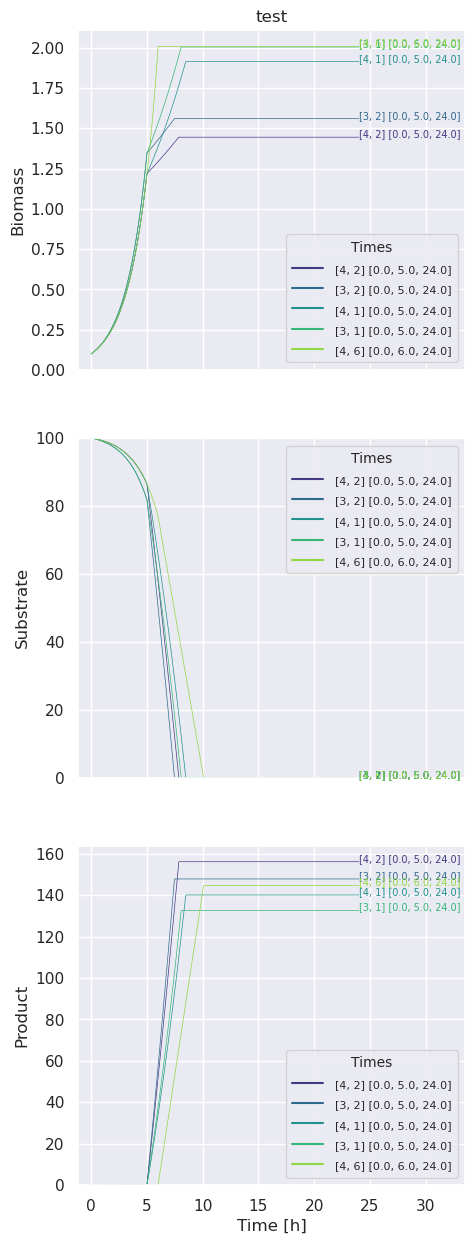

In [8]:
msp.customPlot(brute_best, models_numeric, s, "test")

In [10]:
test_opt = msp.doConvert(best_res3, models_numeric, 0, 24, s)
test_opt

,Index,Times,Models,End_T,End_X,End_S,End_P,finished,Vol_P,Y_SubInput,Y_SubUsed
0,1,"[0.0, 3.36, 5.15, 22.0, 24.0]","[2, 2, 2, 4]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
1,2,"[0.0, 3.26, 6.26, 17.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.45,4,8.41,1.8,1.8
2,3,"[0.0, 4.15, 6.08, 16.07, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
3,4,"[0.0, 3.45, 6.25, 16.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
4,5,"[0.0, 3.32, 6.23, 16.7, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
5,6,"[0.0, 3.32, 6.25, 16.68, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
6,7,"[0.0, 3.36, 6.26, 22.0, 24.0]","[2, 2, 2, 3]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
7,8,"[0.0, 3.36, 6.26, 16.67, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8
8,9,"[0.0, 3.46, 6.25, 22.01, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,3,8.41,1.8,1.8
9,10,"[0.0, 4.27, 5.95, 16.67, 24.0]","[2, 2, 2, 2]",21.46,0.36,0.0,180.44,4,8.41,1.8,1.8


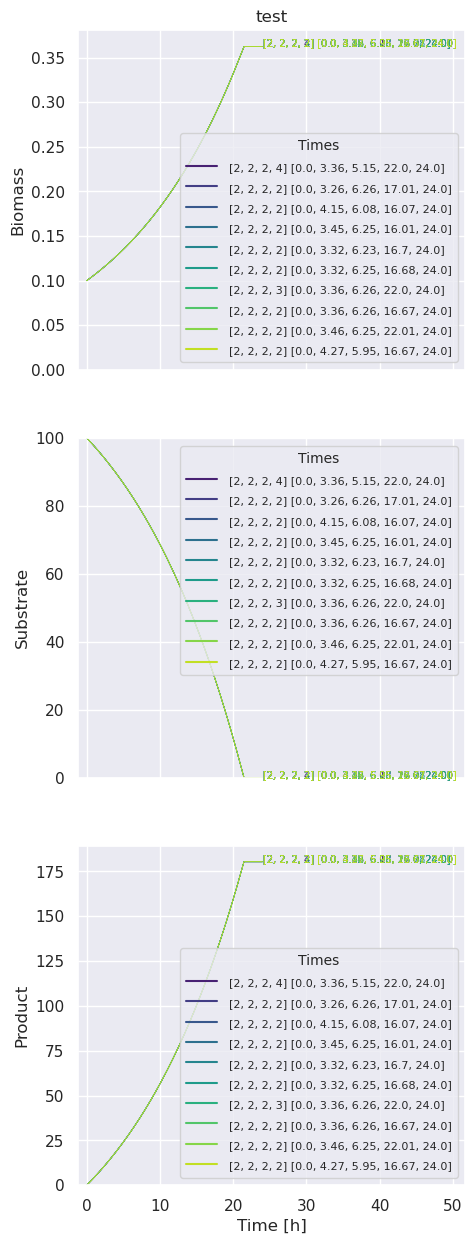

In [11]:
msp.customPlot(test_opt, models_numeric, s, "test")